# Setting up the environment

In [51]:
from google.colab import drive
import os
from google.colab import userdata

# Step 1: Mount Google Drive
# Mount Google Drive to access your GitHub repository
drive.mount('/content/drive', force_remount=True)

# Step 2: Navigate to Your GitHub Repository
# Change to your repository's location in Google Drive
repo_path = "/content/drive/MyDrive/colab_repos/Wav2Vec2-vs-HUbert"  # Adjust to your repository path
os.chdir(repo_path)

# Step 3: Set Git User Identity
# Configure Git with your username and email for committing
!git config --global user.name "FilipLarsson12"
!git config --global user.email "hockeyfilip12@gmail.com"

# Step 4: Configure Git Remote
# Use the GitHub Personal Access Token from secrets for authentication
github_token = userdata.get("github_access_token")  # Retrieve the secret
repo_url = f"https://{github_token}@github.com/FilipLarsson12/Wav2Vec2-vs-HUbert.git"

# Set or update the Git remote
!git remote set-url origin {repo_url}

# Step 5: Stage, Commit, and Push Changes
# Add the file(s) to the Git staging area
!git add "Wav2Vec2forER KEX.ipynb"  # Adjust to your notebook's name

# Commit with a meaningful message
!git commit -m "Updated Google Colab notebook"

# Push to GitHub
!git push origin main  # Push to 'main'


Mounted at /content/drive
[main 9902197] Updated Google Colab notebook
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Wav2Vec2forER KEX.ipynb (87%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 97.55 KiB | 3.61 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/FilipLarsson12/Wav2Vec2-vs-HUbert.git
   85fa1bc..9902197  main -> main


In [52]:
%%capture

!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install jiwer
!pip install torchaudio
!pip install librosa


In [53]:
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8
%env TRANSFORMERS_CACHE=/content/cache
%env HF_DATASETS_CACHE=/content/cache
%env CUDA_LAUNCH_BLOCKING=1

env: LC_ALL=C.UTF-8
env: LANG=C.UTF-8
env: TRANSFORMERS_CACHE=/content/cache
env: HF_DATASETS_CACHE=/content/cache
env: CUDA_LAUNCH_BLOCKING=1


In [54]:
# Monitor the training process
!pip install wandb

In [55]:
# # Uncomment this part if you want to setup your wandb project
from google.colab import userdata
import os
wandb_token = userdata.get("WANDB_TOKEN")

%env WANDB_WATCH=all
%env WANDB_LOG_MODEL=1
%env WANDB_PROJECT=Wav2Vec2forER
!wandb login {wandb_token} --relogin  # Use the secret for authentication


env: WANDB_WATCH=all
env: WANDB_LOG_MODEL=1
env: WANDB_PROJECT=Wav2Vec2forER
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Loading in and preparing the RAVDESS dataset

In [56]:
from datasets import load_dataset

# Set the custom cache directory to your new destination
import os

# Re-load the dataset with the new cache
dataset = load_dataset("narad/ravdess")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for narad/ravdess contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/narad/ravdess
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [57]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

import torchaudio
from sklearn.model_selection import train_test_split

import os
import sys

In [58]:
import torchaudio
import librosa
import IPython.display as ipd
import numpy as np

In [59]:
print(dataset['train'])

Dataset({
    features: ['audio', 'text', 'labels', 'speaker_id', 'speaker_gender'],
    num_rows: 1440
})


Creating label2id and id2label dictionaries to get easier overview of classes and labels.

In [60]:
# Get information about the dataset
print(dataset['train'].features)
label_names = dataset['train'].features['labels'].names
print(label_names)

# Create a dictionary mapping label names to their corresponding IDs
label2id = {name: idx for idx, name in enumerate(label_names)}

# Create a dictionary mapping label IDs to their corresponding label names
id2label = {idx: name for idx, name in enumerate(label_names)}

# Print the dictionaries
print("Label to ID:", label2id)
print("ID to Label:", id2label)

{'audio': Audio(sampling_rate=48000, mono=True, decode=True, id=None), 'text': Value(dtype='string', id=None), 'labels': ClassLabel(names=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'], id=None), 'speaker_id': Value(dtype='string', id=None), 'speaker_gender': Value(dtype='string', id=None)}
['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
Label to ID: {'neutral': 0, 'calm': 1, 'happy': 2, 'sad': 3, 'angry': 4, 'fearful': 5, 'disgust': 6, 'surprised': 7}
ID to Label: {0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'}


In [61]:
df = dataset['train'].to_pandas()

In [62]:
df.head()

,audio,text,labels,speaker_id,speaker_gender
0,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,3,22,female
1,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,4,22,female
2,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,4,22,female
3,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,7,22,female
4,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,3,22,female


Adding an emotion column to the Dataframe to make things more clear.

In [63]:
df["emotion"] = df["labels"].map(id2label)

In [64]:
df.head()

,audio,text,labels,speaker_id,speaker_gender,emotion
0,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,3,22,female,sad
1,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,4,22,female,angry
2,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,4,22,female,angry
3,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,7,22,female,surprised
4,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,3,22,female,sad


Listening to a random sample:

In [65]:
idx = np.random.randint(0, len(df))
sample = df.iloc[idx]

path = sample['audio']["path"]
label = sample["emotion"]


print(f"ID Location: {idx}")
print(f"      Label: {label}")
print()

speech, sr = torchaudio.load(path)
print(path)
print(speech[0])
speech = speech[0].numpy().squeeze()
print(speech)
speech = librosa.resample(y=speech, orig_sr=sr, target_sr=16000)  # Corrected usage
ipd.Audio(data=np.asarray(speech), autoplay=False, rate=16000)

ID Location: 739
      Label: sad

/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_12/03-01-04-02-02-01-12.wav
tensor([ 0.0000,  0.0000,  0.0000,  ..., -0.0016, -0.0016, -0.0016])
[ 0.          0.          0.         ... -0.00161743 -0.00158691
 -0.0015564 ]


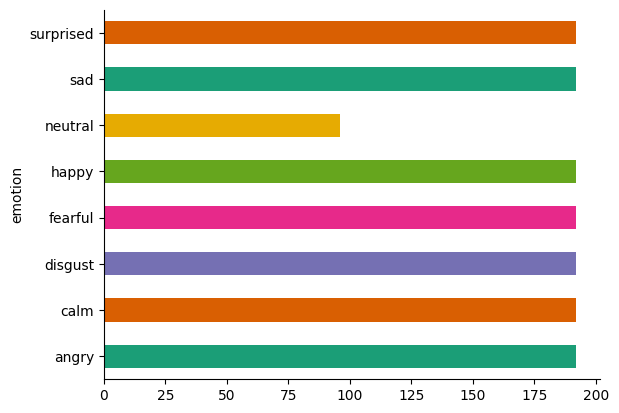

In [66]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [67]:
print("Labels: ", df["emotion"].unique())
print()
df.groupby("emotion").count()['audio']

Labels:  ['sad' 'angry' 'surprised' 'disgust' 'calm' 'happy' 'neutral' 'fearful']



emotion
angry        192
calm         192
disgust      192
fearful      192
happy        192
neutral       96
sad          192
surprised    192
Name: audio, dtype: int64

Restructuring the dataframe a bit for clarity:

In [68]:
df["path"] = df["audio"].apply(lambda audio: audio.get("path", None))



In [69]:
df.head()

,audio,text,labels,speaker_id,speaker_gender,emotion,path
0,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,3,22,female,sad,/content/cache/downloads/extracted/90a2946071f...
1,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,4,22,female,angry,/content/cache/downloads/extracted/90a2946071f...
2,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,4,22,female,angry,/content/cache/downloads/extracted/90a2946071f...
3,"{'bytes': None, 'path': '/content/cache/downlo...",Dogs are sitting by the door,7,22,female,surprised,/content/cache/downloads/extracted/90a2946071f...
4,"{'bytes': None, 'path': '/content/cache/downlo...",Kids are talking by the door,3,22,female,sad,/content/cache/downloads/extracted/90a2946071f...


Now we are gonna split the dataset into a train and test split and also save them into content/data as csv files:

In [70]:
import os

save_path = "/content/data"

os.makedirs(save_path, exist_ok=True)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["labels"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)


print(train_df.shape)
print(test_df.shape)

(1152, 7)
(288, 7)


In [71]:
# Loading the created dataset using datasets
from datasets import load_dataset, load_metric


data_files = {
    "train": "/content/data/train.csv",
    "validation": "/content/data/test.csv",
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
print(dataset['train'][0])
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

print(train_dataset)
print(eval_dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

{'audio': "{'bytes': None, 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_12/03-01-03-02-02-01-12.wav'}", 'text': 'Dogs are sitting by the door', 'labels': 2, 'speaker_id': 12, 'speaker_gender': 'female', 'emotion': 'happy', 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_12/03-01-03-02-02-01-12.wav'}
Dataset({
    features: ['audio', 'text', 'labels', 'speaker_id', 'speaker_gender', 'emotion', 'path'],
    num_rows: 1152
})
Dataset({
    features: ['audio', 'text', 'labels', 'speaker_id', 'speaker_gender', 'emotion', 'path'],
    num_rows: 288
})


In [72]:
unique_labels = df["emotion"].unique()
print(unique_labels)
print(f"A classification problem with {len(unique_labels)} emotions.")

['sad' 'angry' 'surprised' 'disgust' 'calm' 'happy' 'neutral' 'fearful']
A classification problem with 8 emotions.


# Loading in the Wav2Vec2 model

In [73]:
from transformers import AutoConfig, Wav2Vec2Processor

In [74]:
model_name_or_path = "facebook/Wav2Vec2-Base-960h"
pooling_mode = "mean"

In [75]:
print(label2id)
print(id2label)

# config
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=len(unique_labels),
    label2id=label2id,
    id2label=id2label,
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)
print(config)

{'neutral': 0, 'calm': 1, 'happy': 2, 'sad': 3, 'angry': 4, 'fearful': 5, 'disgust': 6, 'surprised': 7}
{0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'}
Wav2Vec2Config {
  "_name_or_path": "facebook/Wav2Vec2-Base-960h",
  "activation_dropout": 0.1,
  "adapter_attn_dim": null,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForCTC"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "sum",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": f

In [76]:
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
target_sampling_rate = processor.feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

The target sampling rate: 16000


In [77]:
all_wav = df['path'].str.endswith('.wav').all()

if all_wav:
    print("All files have the .wav format.")
else:
    print("Not all files have the .wav format.")

All files have the .wav format.


In [78]:
def speech_file_to_array_fn(path):
    try:
        # Load and resample the audio
        speech_array, sampling_rate = torchaudio.load(path)
        resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
        speech = resampler(speech_array)
        speech = speech.flatten()

        # Convert to numpy array
        speech = speech.numpy()

        if len(speech.shape) != 1:
            print("Hej")
            raise ValueError("Expected a 1D numpy array of float values.")

    except Exception as e:
        print(f"Error processing file {path}: {e}")
        # Return a consistent placeholder (empty array)
        speech = np.array([])

    return speech


def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]]

    result = processor(speech_list, sampling_rate=target_sampling_rate)

    return result

In [79]:
print(train_dataset[873:880])  # This can help identify any irregularities


{'audio': ["{'bytes': None, 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_23/03-01-08-01-02-01-23.wav'}", "{'bytes': None, 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_21/03-01-01-01-02-01-21.wav'}", "{'bytes': None, 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_18/03-01-07-01-01-01-18.wav'}", "{'bytes': None, 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_17/03-01-05-02-01-01-17.wav'}", "{'bytes': None, 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_09/03-01-05-02-02-01-09.wav'}", "{'bytes': None, 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_23/03-01-04-01-02-01-23.wav'}", "{'by

In [80]:
train_dataset = train_dataset.filter(lambda x: x["path"] and os.path.exists(x["path"]))
eval_dataset = eval_dataset.filter(lambda x: x["path"] and os.path.exists(x["path"]))


Filter:   0%|          | 0/1152 [00:00<?, ? examples/s]

Filter:   0%|          | 0/288 [00:00<?, ? examples/s]

In [81]:
# Check a range of samples to spot anomalies
for i in range(870, 880):  # Adjust the range as needed
    try:
        # Attempt to access the example and see if it throws errors
        print(f"Sample {i}: ", train_dataset[i])
    except Exception as e:
        print(f"Error at sample {i}: {e}")

Sample 870:  {'audio': "{'bytes': None, 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_05/03-01-02-02-02-01-05.wav'}", 'text': 'Dogs are sitting by the door', 'labels': 1, 'speaker_id': 5, 'speaker_gender': 'male', 'emotion': 'calm', 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_05/03-01-02-02-02-01-05.wav'}
Sample 871:  {'audio': "{'bytes': None, 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_22/03-01-05-02-01-01-22.wav'}", 'text': 'Kids are talking by the door', 'labels': 4, 'speaker_id': 22, 'speaker_gender': 'female', 'emotion': 'angry', 'path': '/content/cache/downloads/extracted/90a2946071fd672392e66dcb12cae53c7db0f9869229dc41def316e96a8dc54b/Actor_22/03-01-05-02-01-01-22.wav'}
Sample 872:  {'audio': "{'bytes': None, 'path': '/content/cache/downloads/extracted/90a2946071fd672392

In [82]:
print(train_dataset.features)  # Check if 'path' is a valid column name

print(len(train_dataset))
# Define a filter function to check if the path exists
def path_exists(example):
    return os.path.exists(example["path"])  # Adjust based on your column name

# Apply the filter to remove invalid paths
train_dataset = train_dataset.filter(path_exists)
print(len(train_dataset))

{'audio': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), 'speaker_id': Value(dtype='int64', id=None), 'speaker_gender': Value(dtype='string', id=None), 'emotion': Value(dtype='string', id=None), 'path': Value(dtype='string', id=None)}
1152


Filter:   0%|          | 0/1152 [00:00<?, ? examples/s]

1152


In [83]:
print(len(train_dataset))
print(len(eval_dataset))

train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)

eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)

print(len(train_dataset))
print(len(eval_dataset))

1152
288


Map (num_proc=4):   0%|          | 0/1152 [00:00<?, ? examples/s]

NameError: name 'input_column' is not defined

In [ ]:
print(train_dataset.features)  # No parentheses
print(train_dataset[0]['attention_mask'])